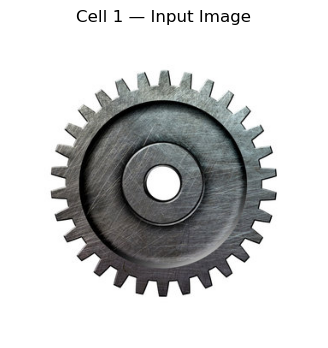

In [1]:
import cv2, numpy as np, json, math, matplotlib.pyplot as plt
from pathlib import Path

# --- Paths (no /mnt) ---
PROJECT_ROOT = Path.cwd()
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Point to your image (change this if needed)
IMG_PATH = PROJECT_ROOT / "gear.jpg"     # e.g., "./gear.jpg"

assert IMG_PATH.exists(), f"Place your image at {IMG_PATH} or update IMG_PATH."

img = cv2.imread(str(IMG_PATH))
assert img is not None, f"Could not read {IMG_PATH}"

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4)); plt.title("Cell 1 — Input Image"); plt.axis("off"); plt.imshow(img_rgb)


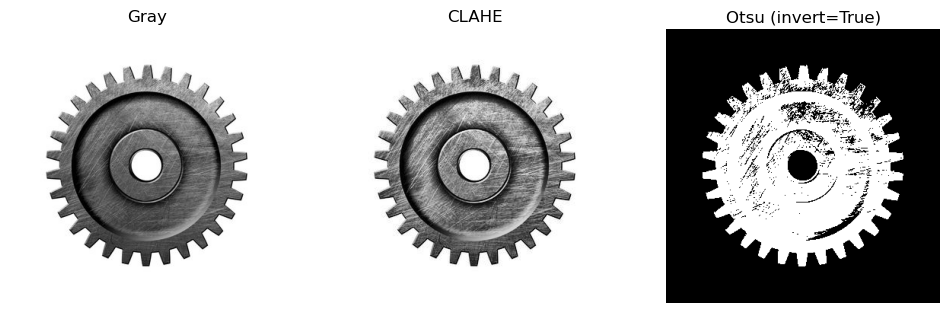

In [2]:
def auto_threshold(gray_img):
    h, w = gray_img.shape
    center = gray_img[h//2-20:h//2+20, w//2-20:w//2+20].mean()
    border = np.concatenate([gray_img[:20,:].ravel(), gray_img[-20:,:].ravel(),
                             gray_img[:, :20].ravel(), gray_img[:, -20:].ravel()]).mean()
    invert = center < border
    flag = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    _, bin_img = cv2.threshold(gray_img, 0, 255, flag + cv2.THRESH_OTSU)
    return bin_img, invert

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

binary, was_inverted = auto_threshold(gray_eq)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Gray"); plt.axis("off"); plt.imshow(gray, cmap="gray")
plt.subplot(1,3,2); plt.title("CLAHE"); plt.axis("off"); plt.imshow(gray_eq, cmap="gray")
plt.subplot(1,3,3); plt.title(f"Otsu (invert={was_inverted})"); plt.axis("off"); plt.imshow(binary, cmap="gray")


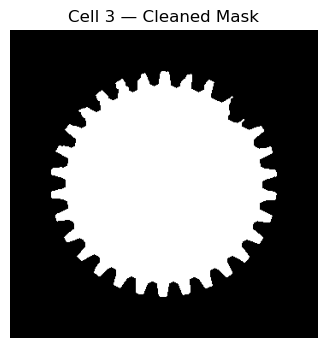

In [3]:
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
k5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, k3, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k5, iterations=2)

# keep largest connected component
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
canvas = np.zeros_like(mask)
if cnts:
    cv2.drawContours(canvas, [max(cnts, key=cv2.contourArea)], -1, 255, -1)
    mask = canvas

cv2.imwrite(str(OUT_DIR/"gear_mask.png"), mask)
plt.figure(figsize=(4,4)); plt.title("Cell 3 — Cleaned Mask"); plt.axis("off"); plt.imshow(mask, cmap="gray")


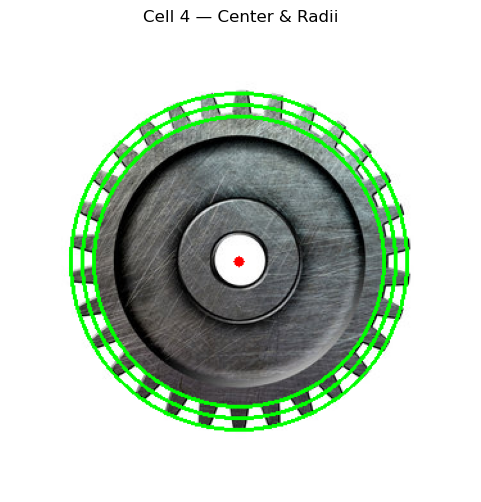

In [4]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
hierarchy = hierarchy[0]
outer_idx = int(np.argmax([cv2.contourArea(c) for c in contours]))
outer = contours[outer_idx]

M = cv2.moments(mask, binaryImage=True)
cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]

def robust_radius(contour, center, top_k=200, mode="max"):
    cx0, cy0 = center
    pts = contour[:,0,:]
    d = np.hypot(pts[:,0]-cx0, pts[:,1]-cy0)
    vals = np.sort(d); k = min(top_k, len(vals))
    return float(np.mean(vals[-k:] if mode=="max" else vals[:k]))

r_add = robust_radius(outer, (cx, cy), mode="max")
r_ded = robust_radius(outer, (cx, cy), mode="min")
r_pitch = 0.5*(r_add + r_ded)

# bore as largest child of outer (may be None if the photo doesn’t show it well)
child_idxs = [i for i,h in enumerate(hierarchy) if h[3]==outer_idx]
r_hole = None
if child_idxs:
    inner = max(child_idxs, key=lambda i: cv2.contourArea(contours[i]))
    r_hole = robust_radius(contours[inner], (cx, cy), mode="max")

diag = img.copy()
for r in [r_ded, r_pitch, r_add]: cv2.circle(diag, (int(cx),int(cy)), int(r), (0,255,0), 2)
if r_hole: cv2.circle(diag, (int(cx),int(cy)), int(r_hole), (255,0,0), 2)
cv2.circle(diag, (int(cx),int(cy)), 4, (0,0,255), -1)
cv2.imwrite(str(OUT_DIR/"gear_circles.png"), diag)

plt.figure(figsize=(6,6)); plt.title("Cell 4 — Center & Radii"); plt.axis("off")
plt.imshow(cv2.cvtColor(diag, cv2.COLOR_BGR2RGB))


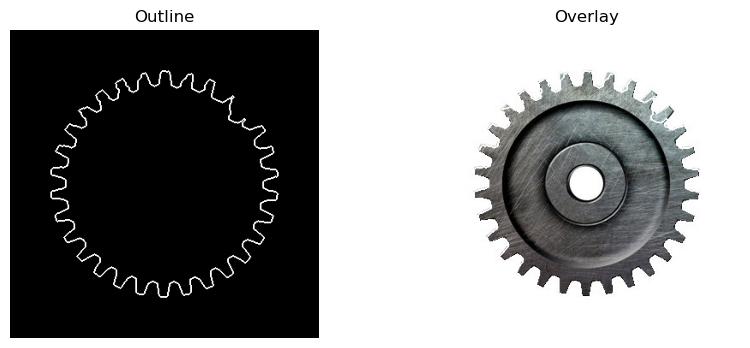

In [5]:
outline = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
_, outline = cv2.threshold(outline, 1, 255, cv2.THRESH_BINARY)

overlay = img.copy()
overlay[np.where(outline==255)] = (255,255,255)

cv2.imwrite(str(OUT_DIR/"gear_outline.png"), outline)
cv2.imwrite(str(OUT_DIR/"gear_overlay.png"), overlay)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Outline"); plt.axis("off"); plt.imshow(outline, cmap="gray")
plt.subplot(1,2,2); plt.title("Overlay"); plt.axis("off"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))


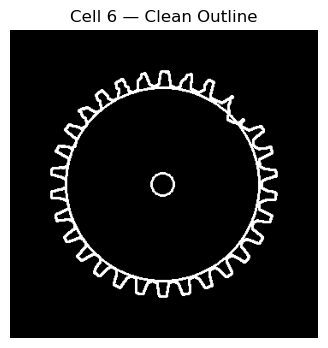

In [6]:
h, w = mask.shape[:2]
clean = np.zeros((h,w), dtype=np.uint8)
cv2.drawContours(clean, [outer], -1, 255, 2)                 
cv2.circle(clean, (int(cx),int(cy)), int(r_ded), 255, 2)     
cv2.circle(clean, (int(cx),int(cy)), int(r_hole or 0.12*r_ded), 255, 2)  

cv2.imwrite(str(OUT_DIR/"gear_outline_clean.png"), clean)
plt.figure(figsize=(4,4)); plt.title("Cell 6 — Clean Outline"); plt.axis("off"); plt.imshow(clean, cmap="gray")


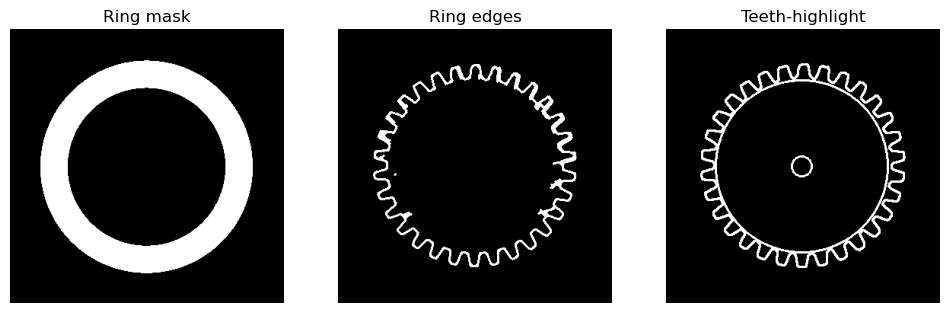

In [7]:
gray_blur = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (5,5), 0)
edges = cv2.Canny(gray_blur, 50, 150)

yy, xx = np.indices(edges.shape)
dist = np.hypot(xx - cx, yy - cy)
MARGIN_IN, MARGIN_OUT = 10, 8  # widen if tips are truncated
ring = ((dist >= (r_ded - MARGIN_IN)) & (dist <= (r_add + MARGIN_OUT))).astype(np.uint8)*255

teeth_edges = cv2.bitwise_and(edges, ring)
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
teeth_edges = cv2.morphologyEx(teeth_edges, cv2.MORPH_DILATE, k, iterations=1)
teeth_edges = cv2.morphologyEx(teeth_edges, cv2.MORPH_CLOSE, k, iterations=2)

cnts, _ = cv2.findContours(teeth_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
teeth_loop = np.zeros_like(teeth_edges)
if cnts:
    cv2.drawContours(teeth_loop, [max(cnts, key=cv2.contourArea)], -1, 255, 2)

teeth_final = np.zeros_like(teeth_loop)
teeth_final = cv2.bitwise_or(teeth_final, teeth_loop)
cv2.circle(teeth_final, (int(cx),int(cy)), int(r_ded), 255, 2)
cv2.circle(teeth_final, (int(cx),int(cy)), int(r_hole or 0.12*r_ded), 255, 2)

cv2.imwrite(str(OUT_DIR/"gear_teeth_outline.png"), teeth_final)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Ring mask"); plt.axis("off"); plt.imshow(ring, cmap="gray")
plt.subplot(1,3,2); plt.title("Ring edges"); plt.axis("off"); plt.imshow(teeth_edges, cmap="gray")
plt.subplot(1,3,3); plt.title("Teeth-highlight"); plt.axis("off"); plt.imshow(teeth_final, cmap="gray")


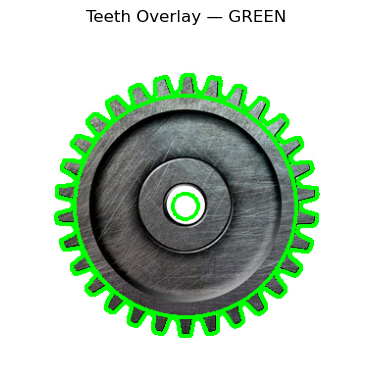

In [8]:
assert 'teeth_final' in globals() and 'img' in globals(), "Run through Cell 7 first."

def overlay_teeth_highlight(img_bgr, teeth_mask, color="green", thickness=2, alpha=1.0):
    color = color.lower()
    color_bgr = (0,255,0) if color == "green" else (255,255,255)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (max(1,thickness), max(1,thickness)))
    thick = cv2.dilate(teeth_mask, k, iterations=1)
    
    color_layer = np.full_like(img_bgr, color_bgr, dtype=np.uint8)
    m3 = (thick > 0).astype(np.float32)[..., None]
    out = (img_bgr.astype(np.float32)*(1 - alpha*m3) + color_layer.astype(np.float32)*(alpha*m3)).astype(np.uint8)
    return out


overlay_green = overlay_teeth_highlight(img, teeth_final, color="green", thickness=2, alpha=1.0)


(OUT_DIR / "gear_teeth_overlay_green.png").parent.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(OUT_DIR / "gear_teeth_overlay_green.png"), overlay_green)



plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Teeth Overlay — GREEN"); plt.axis("off"); plt.imshow(cv2.cvtColor(overlay_green, cv2.COLOR_BGR2RGB))



In [9]:
def tooth_count_fft(outer_contour, cx, cy):
    pts = outer_contour[:,0,:]
    theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
    r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    idx = np.argsort(theta); theta, r = theta[idx], r[idx]
    theta2 = np.concatenate([theta, theta + 2*np.pi])
    r2 = np.concatenate([r, r])
    N = 4096
    tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
    rgrid = np.interp(tgrid, theta2, r2)
    kernel = np.ones(51)/51.0
    r_det = rgrid - np.convolve(rgrid, kernel, mode="same")
    F = np.fft.rfft(r_det)
    freqs = np.fft.rfftfreq(N, d=(2*np.pi/N))
    mask = (freqs >= 6) & (freqs <= 200)
    if not np.any(mask): return None
    return int(freqs[mask][np.argmax(np.abs(F[mask]))].round())

teeth_est = tooth_count_fft(outer, cx, cy)
m_px = (2.0 * r_pitch / teeth_est) if (teeth_est and teeth_est > 0) else None
p_circ_px = (math.pi * m_px) if m_px else None

results = {
    "center_px": [float(cx), float(cy)],
    "r_add_px": float(r_add),
    "r_ded_px": float(r_ded),
    "r_pitch_px": float(r_pitch),
    "r_hole_px": None if r_hole is None else float(r_hole),
    "teeth_estimate": None if teeth_est is None else int(teeth_est),
    "module_px": None if m_px is None else float(m_px),
    "circular_pitch_px": None if p_circ_px is None else float(p_circ_px),
}
with open(OUT_DIR/"gear_measurements.json", "w") as f:
    json.dump(results, f, indent=2)

print(json.dumps(results, indent=2))
print("\nSaved to:", OUT_DIR.resolve())


{
  "center_px": [
    178.94410359834413,
    180.57297526801827
  ],
  "r_add_px": 131.6128218560393,
  "r_ded_px": 113.59807942315285,
  "r_pitch_px": 122.60545063959607,
  "r_hole_px": null,
  "teeth_estimate": 10,
  "module_px": 24.521090127919216,
  "circular_pitch_px": 77.03527660388421
}

Saved to: /Users/kushagrapandey/Downloads/BTech_Project/outputs
